<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula06c_mlp_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

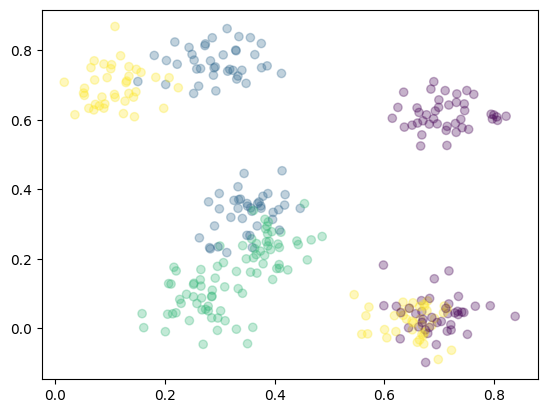

In [22]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def make_dataset(n=400, n_classes=4):
  X, y = make_blobs(n_samples=n,
                    centers=n_classes*2,
                    center_box=(0,1),
                    cluster_std=0.05)
  y = y % n_classes
  return X, y

X, y = make_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def plot_dataset(X, y):
  plt.scatter(X[:,0], X[:,1], c=y, alpha=0.3)

plot_dataset(X_train, y_train)
plt.show()

In [13]:
def define_axes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

train: 0.721875
test: 0.675


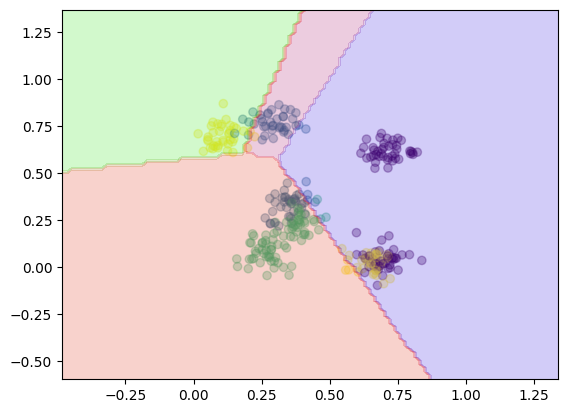

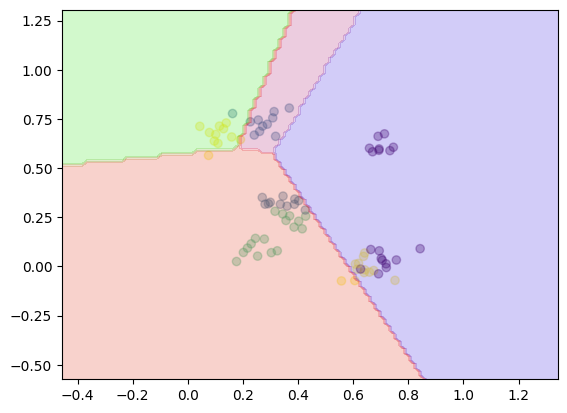

In [41]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class SLPClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=2000):
    self.max_iter = max_iter
    self.model = None

  def fit(self, X, y):
    self.labels, ids = np.unique(y, return_inverse=True)
    input_shape = X.shape[1]
    output_shape = len(self.labels)

    y_tensor = torch.tensor(ids, dtype=torch.long)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    self.model = nn.Sequential(
        nn.Linear(input_shape, output_shape),
        nn.Softmax(dim=1)
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(self.model.parameters())
    for epoch in range(self.max_iter):
      optimizer.zero_grad()
      outputs = self.model(X_tensor)
      loss = criterion(outputs, y_tensor)
      loss.backward()
      optimizer.step()

    return self

  def predict_proba(self, X):
    with torch.no_grad():
      X_tensor = torch.tensor(X, dtype=torch.float32)
      outputs = self.model(X_tensor)
      return outputs.numpy()

  def predict(self, X):
    ypred = np.argmax(self.predict_proba(X), axis=1)
    return self.labels[ypred]

model = SLPClassifier()
model.fit(X_train, y_train)
ypred = model.predict(X_train)
print("train:", accuracy_score(y_train, ypred))
y_pred = model.predict(X_test)
print("test:", accuracy_score(y_test, y_pred))

plot_dataset(X_train, y_train)
plot_predictions(model, X_train)
plt.show()

plot_dataset(X_test, y_test)
plot_predictions(model, X_test)
plt.show()

train: 0.853125
test: 0.8


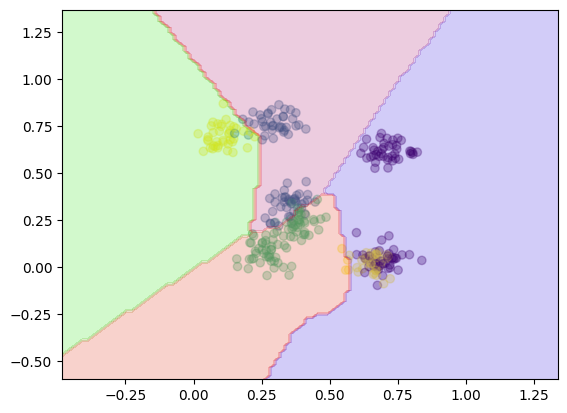

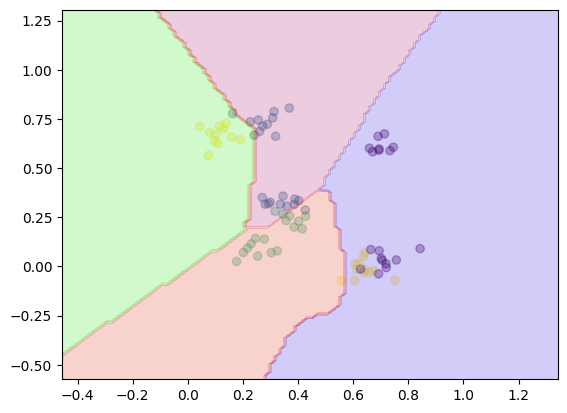

In [44]:
class SHLPClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=10000):
    self.max_iter = max_iter
    self.model = None

  def fit(self, X, y):
    self.labels, ids = np.unique(y, return_inverse=True)
    input_shape = X.shape[1]
    output_shape = len(self.labels)

    y_tensor = torch.tensor(ids, dtype=torch.long)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    self.model = nn.Sequential(
        nn.Linear(input_shape, 100),
        nn.ReLU(),
        nn.Linear(100, output_shape),
        nn.Softmax(dim=1)
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(self.model.parameters())
    for epoch in range(self.max_iter):
      optimizer.zero_grad()
      outputs = self.model(X_tensor)
      loss = criterion(outputs, y_tensor)
      loss.backward()
      optimizer.step()

    return self

  def predict_proba(self, X):
    with torch.no_grad():
      X_tensor = torch.tensor(X, dtype=torch.float32)
      outputs = self.model(X_tensor)
      return outputs.numpy()

  def predict(self, X):
    ypred = np.argmax(self.predict_proba(X), axis=1)
    return self.labels[ypred]

model = SHLPClassifier()
model.fit(X_train, y_train)
ypred = model.predict(X_train)
print("train:", accuracy_score(y_train, ypred))
y_pred = model.predict(X_test)
print("test:", accuracy_score(y_test, y_pred))

plot_dataset(X_train, y_train)
plot_predictions(model, X_train)
plt.show()

plot_dataset(X_test, y_test)
plot_predictions(model, X_test)
plt.show()

train: 0.85
test: 0.8


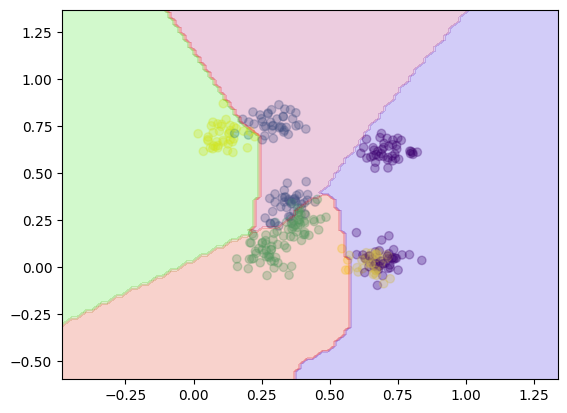

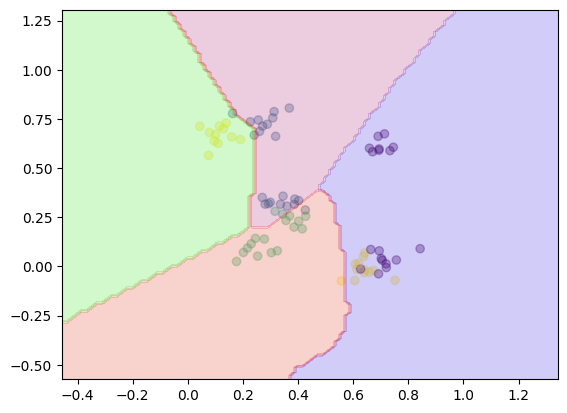

In [45]:
class MLPClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=10000, n_hidden=[100]):
    self.max_iter = max_iter
    self.n_hidden = n_hidden
    self.model = None

  def fit(self, X, y):
    self.labels, ids = np.unique(y, return_inverse=True)
    input_shape = X.shape[1]
    output_shape = len(self.labels)

    y_tensor = torch.tensor(ids, dtype=torch.long)
    X_tensor = torch.tensor(X, dtype=torch.float32)

    layers = [nn.Linear(input_shape, self.n_hidden[0]), nn.ReLU()]
    for i in range(1, len(self.n_hidden)):
      layers.append(nn.Linear(self.n_hidden[i-1], self.n_hidden[i]))
      layers.append(nn.ReLU())
    layers.append(nn.Linear(self.n_hidden[-1], output_shape))
    layers.append(nn.Softmax(dim=1))
    self.model = nn.Sequential(*layers)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(self.model.parameters())

    for epoch in range(self.max_iter):
      optimizer.zero_grad()
      outputs = self.model(X_tensor)
      loss = criterion(outputs, y_tensor)
      loss.backward()
      optimizer.step()

    return self

  def predict_proba(self, X):
    with torch.no_grad():
      X_tensor = torch.tensor(X, dtype=torch.float32)
      outputs = self.model(X_tensor)
      return outputs.numpy()

  def predict(self, X):
    ypred = np.argmax(self.predict_proba(X), axis=1)
    return self.labels[ypred]


model = MLPClassifier()
model.fit(X_train, y_train)
ypred = model.predict(X_train)
print("train:", accuracy_score(y_train, ypred))
y_pred = model.predict(X_test)
print("test:", accuracy_score(y_test, y_pred))

plot_dataset(X_train, y_train)
plot_predictions(model, X_train)
plt.show()

plot_dataset(X_test, y_test)
plot_predictions(model, X_test)
plt.show()